<a href="https://colab.research.google.com/github/ilaig2/siren/blob/master/siren_small_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from glob import glob
image_paths = glob('/content/drive/MyDrive/Data/48/*.png')

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen,  dim=2, min_val=-1, max_val=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(min_val, max_val, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [4]:
from collections import OrderedDict
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30., **kwargs):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

#Ilai: My code starts here

(All the code above is from the original Siren repo, unchanged)

# Fitting multiple images

By adding adding an additional `k` sized embedding represntation the image index in the dataset

In [116]:
class ImageEmbedding(nn.Module):
      def __init__(self, num_images, hidden_size, embedding_size, embedding_bias=True, nl='relu', **kwargs):
        super().__init__()
        self.num_images = num_images
        self.nl_type = nl
        self.linear1 = nn.Linear(num_images, hidden_size, bias=embedding_bias)
        self.linear2 = nn.Linear(hidden_size, embedding_size, bias=embedding_bias)

        if nl == 'relu':
          self.nl1 = nn.ReLU()
          self.nl2 = nn.ReLU()

        
        self.init_weights()

      def init_weights(self):
        for m in [self.linear1, self.linear2]:
          if type(m) == nn.Linear:
            if hasattr(m, 'weight'):
                nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity=self.nl_type, mode='fan_in')
            if hasattr(m, 'weight'):
                m.bias.data.fill_(0.01)

      def forward(self, image_idx):
        image_idx = image_idx.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        hidden = self.nl1(self.linear1(image_idx))
        output = self.nl2(self.linear2(hidden))
        return output

class MultiImageSiren(nn.Module):
      def __init__(self, in_features, num_images, embedding_size, hidden_features, hidden_layers, out_features, **kwargs):
        super().__init__()
        self.embedder_net = ImageEmbedding(num_images, hidden_features, embedding_size, **kwargs)
        self.siren = Siren(in_features + embedding_size, hidden_features, hidden_layers, out_features, **kwargs)

      def forward(self, coords, image_idx, embedding=None):
        if embedding is None: # Only used in the last part, "interpolation":
          embedding = self.embedder_net(image_idx)
        expand_dims = (-1, coords.shape[-2], -1) if embedding.ndim == 3 else (coords.shape[-2], -1)
        sine_input = torch.cat((coords, embedding.expand(*expand_dims)), dim=-1)
        pixels, _ = self.siren(sine_input)
        return pixels, embedding



In [117]:
def image_transforms(img , sidelength):
      transform = Compose([
        Resize((sidelength, sidelength)),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
      ])
      img = transform(img)
      return img

class MultiImageFitting(Dataset):
    def __init__(self, sidelength, image_paths):
        super().__init__()
        self.sidelength = sidelength
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):    
        img = Image.open(self.image_paths[idx])
        img = image_transforms(img, self.sidelength)
        pixels = img.permute(1, 2, 0).view(-1, img.shape[0])
        pixels = pixels[:, :3]
        coords = get_mgrid(self.sidelength, 2)
        
        one_hot_idx = F.one_hot(torch.tensor([idx]), num_classes=len(self.image_paths)).float()
            
        return coords, one_hot_idx, pixels

In [147]:
SIDELENGTH = 48
NUM_IMAGES = len(image_paths)
EMBEDDING_SIZE = 8
BATCH_SIZE = 100 # Wich essentially means "real" gradient decsent, not SGD
# BATCH_SIZE = 32 

device='cuda'
# device='cpu'

img_siren = MultiImageSiren(in_features=2, num_images=NUM_IMAGES, 
                            embedding_size=EMBEDDING_SIZE,
                            out_features=3, hidden_features=256, 
                            hidden_layers=3, outermost_linear=True)


images_48_ds = MultiImageFitting(SIDELENGTH, image_paths)
dataloader = DataLoader(images_48_ds, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0)

img_siren.to(device)

MultiImageSiren(
  (embedder_net): ImageEmbedding(
    (linear1): Linear(in_features=100, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=8, bias=True)
    (nl1): ReLU()
    (nl2): ReLU()
  )
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=10, out_features=256, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (3): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (4): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)

In [121]:
total_steps = 2000
steps_til_summary = 50
best_loss = 1e6
CKPT_NAME = f'img_siren_side_{SIDELENGTH}_embedding_{EMBEDDING_SIZE}_batch_{BATCH_SIZE}.pth'
CKPT_PATH = os.path.join('/content/drive/MyDrive/model_ckpts/', CKPT_NAME)

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

for step in range(total_steps):
  epoch_loss = 0
  for coords, one_hot_idx, ground_truth in dataloader:
    coords, one_hot_idx, ground_truth = coords.cuda(), one_hot_idx.cuda(), ground_truth.cuda()
    model_output, embdedding = img_siren(coords, one_hot_idx)    
    loss = ((model_output - ground_truth)**2).mean()
    epoch_loss += ((model_output.detach() - ground_truth.detach())**2).view(model_output.shape[0], -1).mean(dim=1).sum()

    optim.zero_grad()
    loss.backward()
    optim.step()

  epoch_loss = epoch_loss / len(dataloader.dataset)
  if not step % steps_til_summary:
    print("Step %d, Total loss %0.6f" % (step, epoch_loss))
    if epoch_loss < best_loss:
      torch.save(img_siren.state_dict(), CKPT_PATH)
      best_loss = epoch_loss

Step 0, Total loss 0.813163
Step 50, Total loss 0.243751
Step 100, Total loss 0.216476
Step 150, Total loss 0.179574
Step 200, Total loss 0.131626
Step 250, Total loss 0.094710
Step 300, Total loss 0.072846
Step 350, Total loss 0.058787
Step 400, Total loss 0.050695
Step 450, Total loss 0.043789
Step 500, Total loss 0.036624
Step 550, Total loss 0.031433
Step 600, Total loss 0.028230
Step 650, Total loss 0.025670
Step 700, Total loss 0.022840
Step 750, Total loss 0.021170
Step 800, Total loss 0.019162
Step 850, Total loss 0.017612
Step 900, Total loss 0.016316
Step 950, Total loss 0.015039
Step 1000, Total loss 0.014294
Step 1050, Total loss 0.013052
Step 1100, Total loss 0.012596
Step 1150, Total loss 0.011576
Step 1200, Total loss 0.011005
Step 1250, Total loss 0.010197
Step 1300, Total loss 0.009674
Step 1350, Total loss 0.009135
Step 1400, Total loss 0.008772
Step 1450, Total loss 0.008519
Step 1500, Total loss 0.008102
Step 1550, Total loss 0.007543
Step 1600, Total loss 0.007491


KeyboardInterrupt: ignored

Best losses so far:

1. ~`embedding_size=256`, `batch_size=32` (about 2000 steps): `0.09` (epoch loss calculated incorrectly, need to repeat)~  
2. ~`embedding_size=512`, `batch_size=100` (about 1800 steps): `0.019`~  
3. ~`embedding_size=512`, `batch_size=32` (about 1700 steps): `0.021`~  
4. ~Continue training (2.) with `lr=1e-5`(additional 1400 epochs): `0.01`~

All above were achieved with no hidden layer in the embedder == very large embedding vector
With `embedding_size=8` and `hidden_features=256` (after 1800 epochs): `0.006`

In [148]:
#BEST_CKPT_PATH = '/content/drive/MyDrive/model_ckpts/img_siren_side_48_embedding_512_batch_100.pth'
# BEST_CKPT_PATH = '/content/drive/MyDrive/model_ckpts/img_siren_side_48_embedding_512_batch_100_cont_lr_e-5.pth'

BEST_CKPT_PATH = '/content/drive/MyDrive/model_ckpts/img_siren_side_48_embedding_8_batch_100.pth'

In [149]:
device = torch.device('cuda')
img_siren.load_state_dict(torch.load(BEST_CKPT_PATH, map_location=device))
img_siren.eval() # Kinda meaningless, since the model has no layers that behave differently between train \ eval.

MultiImageSiren(
  (embedder_net): ImageEmbedding(
    (linear1): Linear(in_features=100, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=8, bias=True)
    (nl1): ReLU()
    (nl2): ReLU()
  )
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=10, out_features=256, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (3): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (4): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)

# Verify and visualize trained model forward()

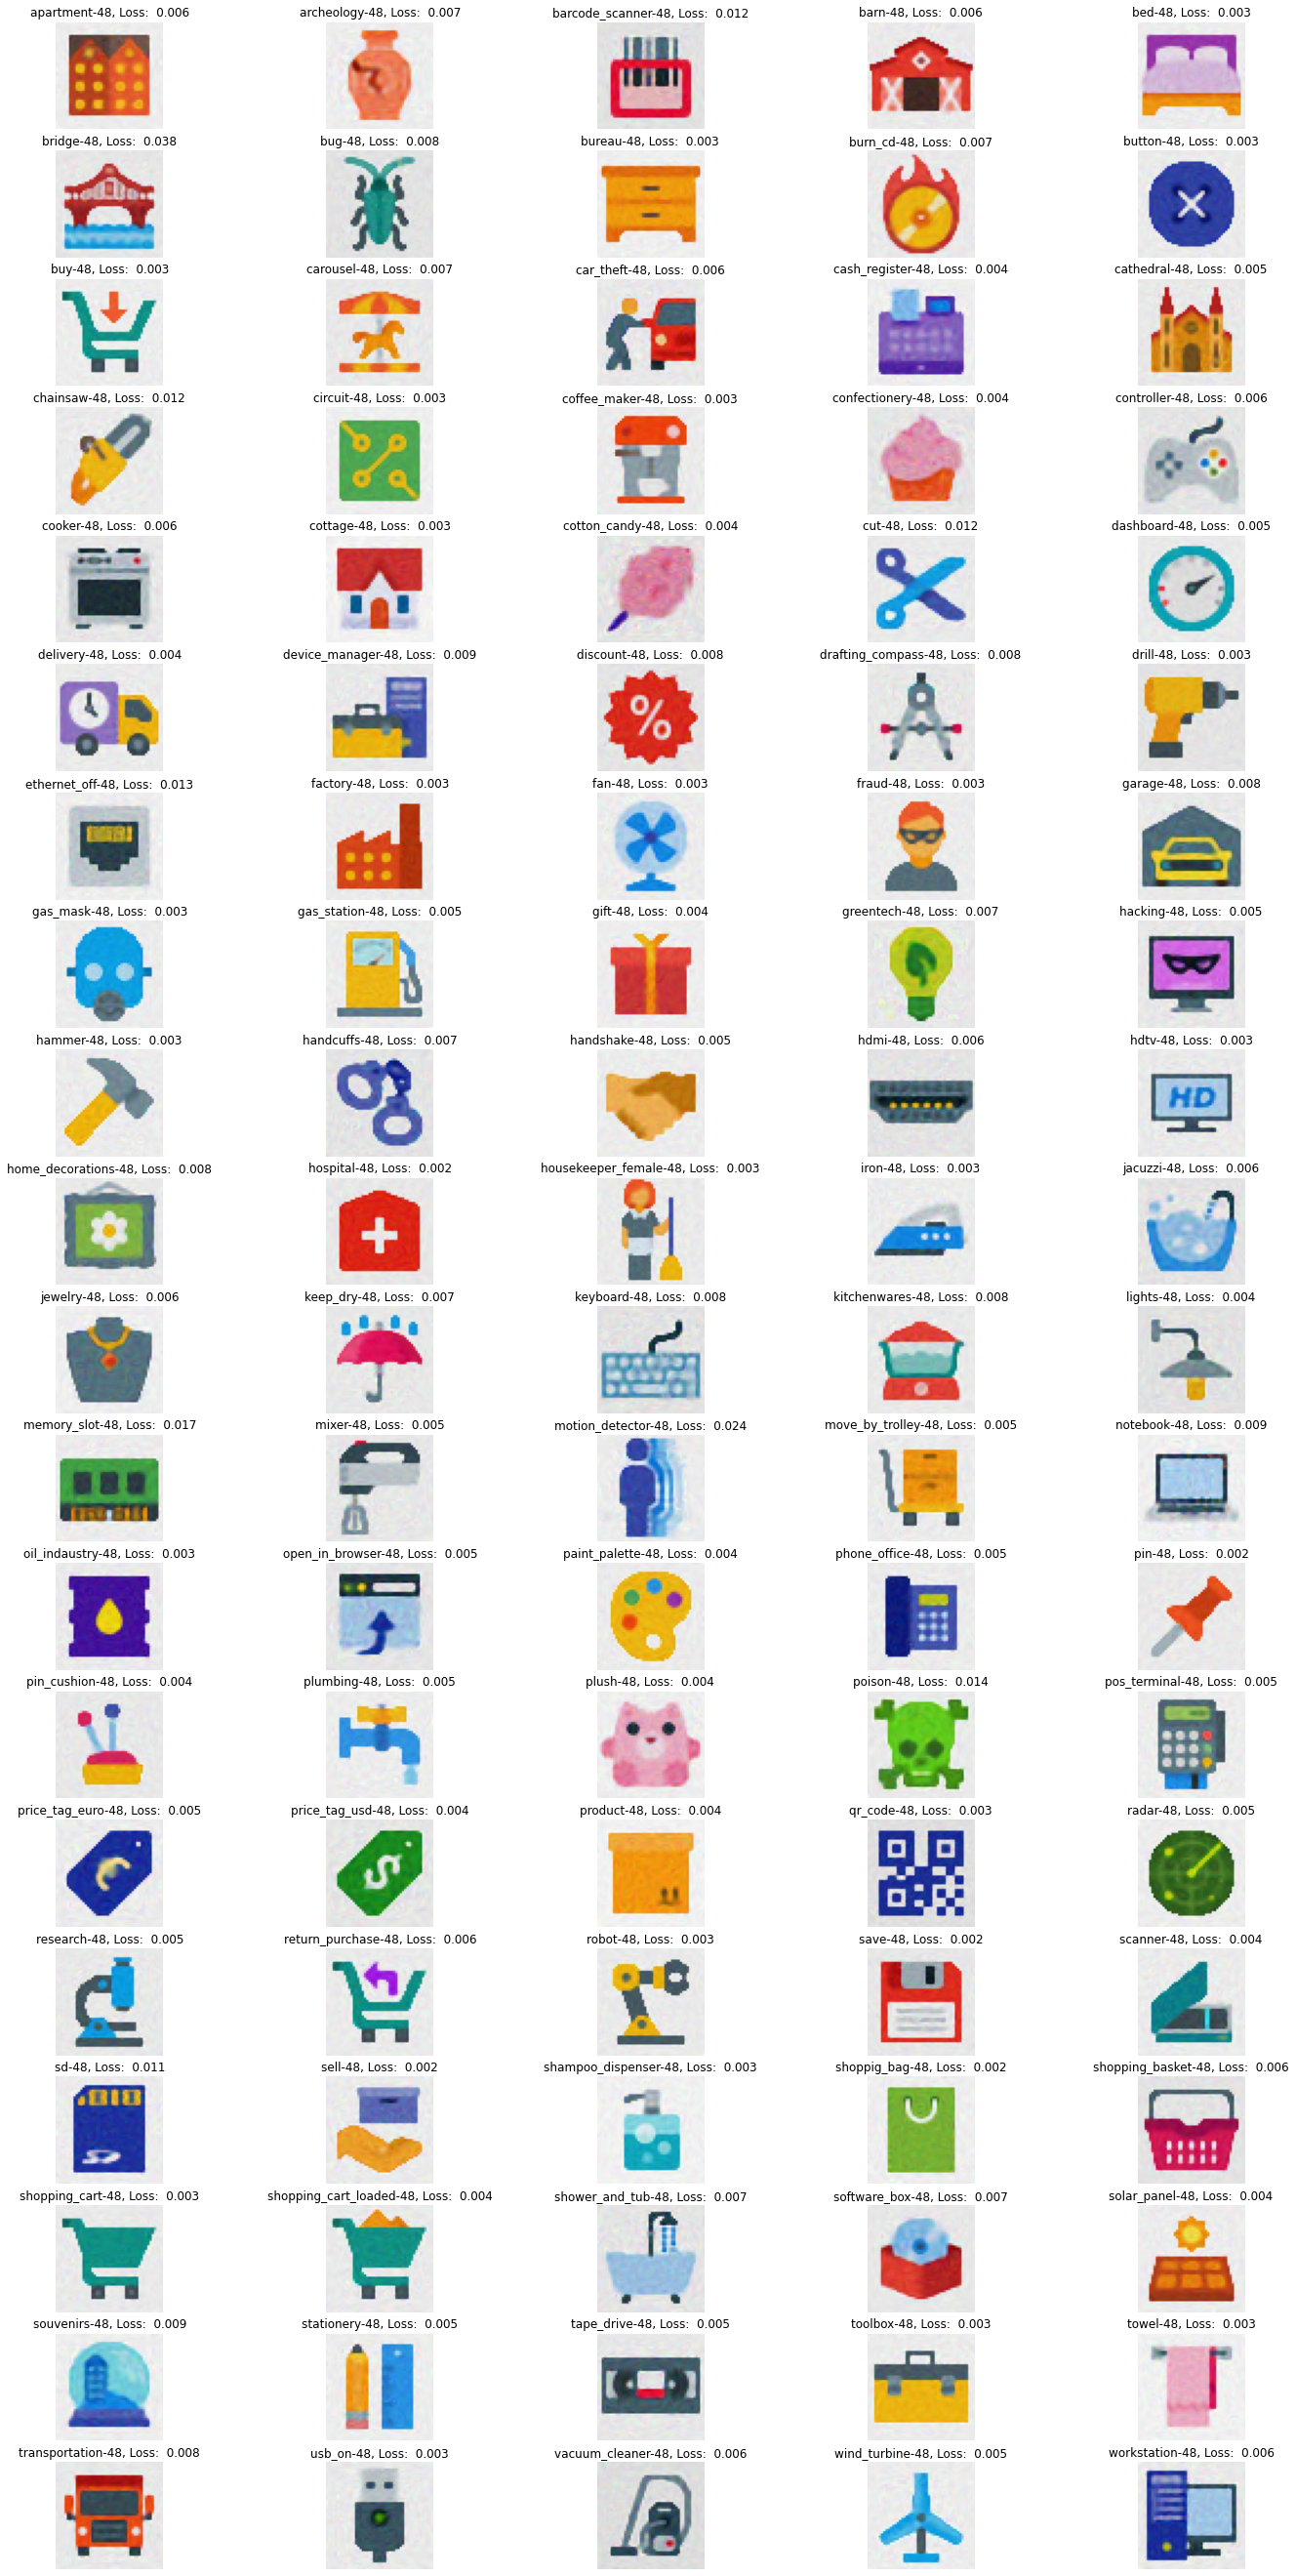

In [151]:
def plot_all_images(dataloader):

  with torch.no_grad():
    for i, (coords, one_hot_idx, GT) in enumerate(dataloader):
        model_output, _ = img_siren(coords.cuda(), one_hot_idx.cuda())
        model_output = model_output.cpu()
        loss = ((model_output - GT)**2).mean()
        model_output = model_output.view(NEW_SIDELENGTH,NEW_SIDELENGTH, 3).numpy()
        model_output -= model_output.min()
        model_output /= (model_output.max() - model_output.min())
        axs[(i //5) % 20, i % 5].imshow(model_output, cmap='gray')
        axs[(i //5) % 20, i % 5].set_title(f"{os.path.splitext(os.path.basename(image_paths[i]))[0]}, Loss: {loss : .3f}")
        axs[(i //5) % 20, i % 5].axis(False)

fig, axs = plt.subplots(20, 5, figsize=[24,48])
dataloader = DataLoader(images_48_ds, batch_size=1, pin_memory=True, num_workers=0)
plot_all_images(dataloader)

# Explore generalization
Let's deny the model one quarter of the image - one corner (top left, bottom right etc) from each image.   
We'll start by cropping different parts from each image - so that the model is overall trained with the full coordiante space.


First, let's define training loop with evaluation on a validation set.  
The validation set would be the "full" images, uncropped

In [129]:
def eavluate(model, val_dataloader):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
      for coords, one_hot_idx, ground_truth in val_dataloader:
        coords, one_hot_idx, ground_truth = coords.to(device), one_hot_idx.to(device), ground_truth.to(device)
        model_output, _ = model(coords, one_hot_idx)
        epoch_loss += ((model_output.detach() - ground_truth.detach())**2).view(model_output.shape[0], -1).mean(dim=1).sum()
      
      epoch_loss = epoch_loss / len(val_dataloader.dataset)
  
  model.train()
  return epoch_loss

In [130]:
def trainig_loop(model, train_dataloader, val_dataloader, total_steps=2000, steps_til_summary=50):
  optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

  for step in range(total_steps):
    epoch_loss = 0
    for coords, one_hot_idx, ground_truth in train_dataloader:
      coords, one_hot_idx, ground_truth = coords.to(device), one_hot_idx.to(device), ground_truth.to(device)
      model_output, embdedding = model(coords, one_hot_idx)    
      loss = ((model_output - ground_truth)**2).mean()
      epoch_loss += ((model_output.detach() - ground_truth.detach())**2).view(model_output.shape[0], -1).mean(dim=1).sum()

      optim.zero_grad()
      loss.backward()
      optim.step()

    epoch_loss = epoch_loss / len(train_dataloader.dataset)
    if step % steps_til_summary == 0:
      val_loss = eavluate(model, val_dataloader)
      print(f"Epoch {step}, Train loss {epoch_loss :0.4f}, Val loss {val_loss :0.4f}")

Now we will build a dataset that pre-determines which corner (top left, top right, bottom left etc) to remove from each image.  
The behaviour per image is randomized - but remains the same throughout the entire training cycle.

In [ ]:
def mask_out_corner(img:np.ndarray, portion: float, sidelength:int,
                   corner:str = 'tl') -> np.ndarray:
  del_side = int(portion * sidelength)

  crop_val = torch.Tensor([-100] * img.shape[-1])
  if corner == 'tl':
    img[:del_side, :del_side, :] = crop_val
  elif corner == 'tr':
    img[:del_side, (sidelength - del_side) : sidelength , :] = crop_val
  elif corner == 'bl':
    img[(sidelength - del_side) : sidelength, :del_side, :] = crop_val
  elif corner == 'br':
    img[(sidelength - del_side) : sidelength, 
        (sidelength - del_side) : sidelength, :] = crop_val

  return img


class MultiImageFittingPartialRand(Dataset):
    def __init__(self, sidelength:int, image_paths:list, del_portion:float = 1):
        super().__init__()
        self.sidelength = sidelength
        self.del_portion = del_portion
        self.image_paths = image_paths
        self.corners = [np.random.choice(['tl', 'tr', 'bl', 'br']) for _ in range(len(image_paths))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):    
        img = Image.open(self.image_paths[idx])
        img = image_transforms(img, self.sidelength)
        img = img.permute(1, 2, 0)
        
        # Randomly delete one part of the image (ugly implementation, but it'll work...)
        corner = self.corners[idx]
        img = mask_out_corner(img, self.del_portion, self.sidelength, corner)
        pixels = img.reshape(-1, img.shape[-1])
        pixels = pixels[:, :3]
        mask_2d = pixels[:, 0] != -100
        pixels = pixels[mask_2d, :]
        coords = get_mgrid(self.sidelength, 2)
        coords = coords[mask_2d, :]
        
        one_hot_idx = F.one_hot(torch.tensor([idx]), num_classes=len(self.image_paths)).float()
            
        return coords, one_hot_idx, pixels

In [137]:
SIDELENGTH = 48
BATCH_SIZE = 100 # Wich essentially means "real" gradient decsent, not SGD
# BATCH_SIZE = 16

device='cuda'
# device='cpu'

# TODO: add model.init_weights(), so I don't need to instantiate a new obj every time...
img_siren = MultiImageSiren(in_features=2, num_images=NUM_IMAGES, 
                            embedding_size=EMBEDDING_SIZE,
                            out_features=3, hidden_features=256, 
                            hidden_layers=3, outermost_linear=True)

img_siren.to(device)

# Create a train ds that removes one corner from each image (both coordinates and pixels)
train_ds = MultiImageFittingPartialRand(SIDELENGTH, image_paths, 0.5)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

# Create a validation ds that loads the full images
val_ds = MultiImageFittingPartialRand(SIDELENGTH, image_paths, 0)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

In [138]:
trainig_loop(img_siren, train_dataloader, val_dataloader, total_steps=1800, steps_til_summary=50)

Epoch 0, Train loss 0.7536, Val loss 0.5917
Epoch 50, Train loss 0.2436, Val loss 0.2531
Epoch 100, Train loss 0.2084, Val loss 0.2213
Epoch 150, Train loss 0.1611, Val loss 0.1870
Epoch 200, Train loss 0.1146, Val loss 0.1541
Epoch 250, Train loss 0.0839, Val loss 0.1340
Epoch 300, Train loss 0.0650, Val loss 0.1230
Epoch 350, Train loss 0.0536, Val loss 0.1163
Epoch 400, Train loss 0.0445, Val loss 0.1101
Epoch 450, Train loss 0.0382, Val loss 0.1059
Epoch 500, Train loss 0.0336, Val loss 0.1035
Epoch 550, Train loss 0.0299, Val loss 0.1017
Epoch 600, Train loss 0.0261, Val loss 0.0999
Epoch 650, Train loss 0.0237, Val loss 0.0989
Epoch 700, Train loss 0.0213, Val loss 0.0978
Epoch 750, Train loss 0.0194, Val loss 0.0973
Epoch 800, Train loss 0.0179, Val loss 0.0967
Epoch 850, Train loss 0.0165, Val loss 0.0962
Epoch 900, Train loss 0.0155, Val loss 0.0962
Epoch 950, Train loss 0.0145, Val loss 0.0958
Epoch 1000, Train loss 0.0136, Val loss 0.0955
Epoch 1050, Train loss 0.0128, Val l

KeyboardInterrupt: ignored

Let's see what this model is doing if we try to draw the images:

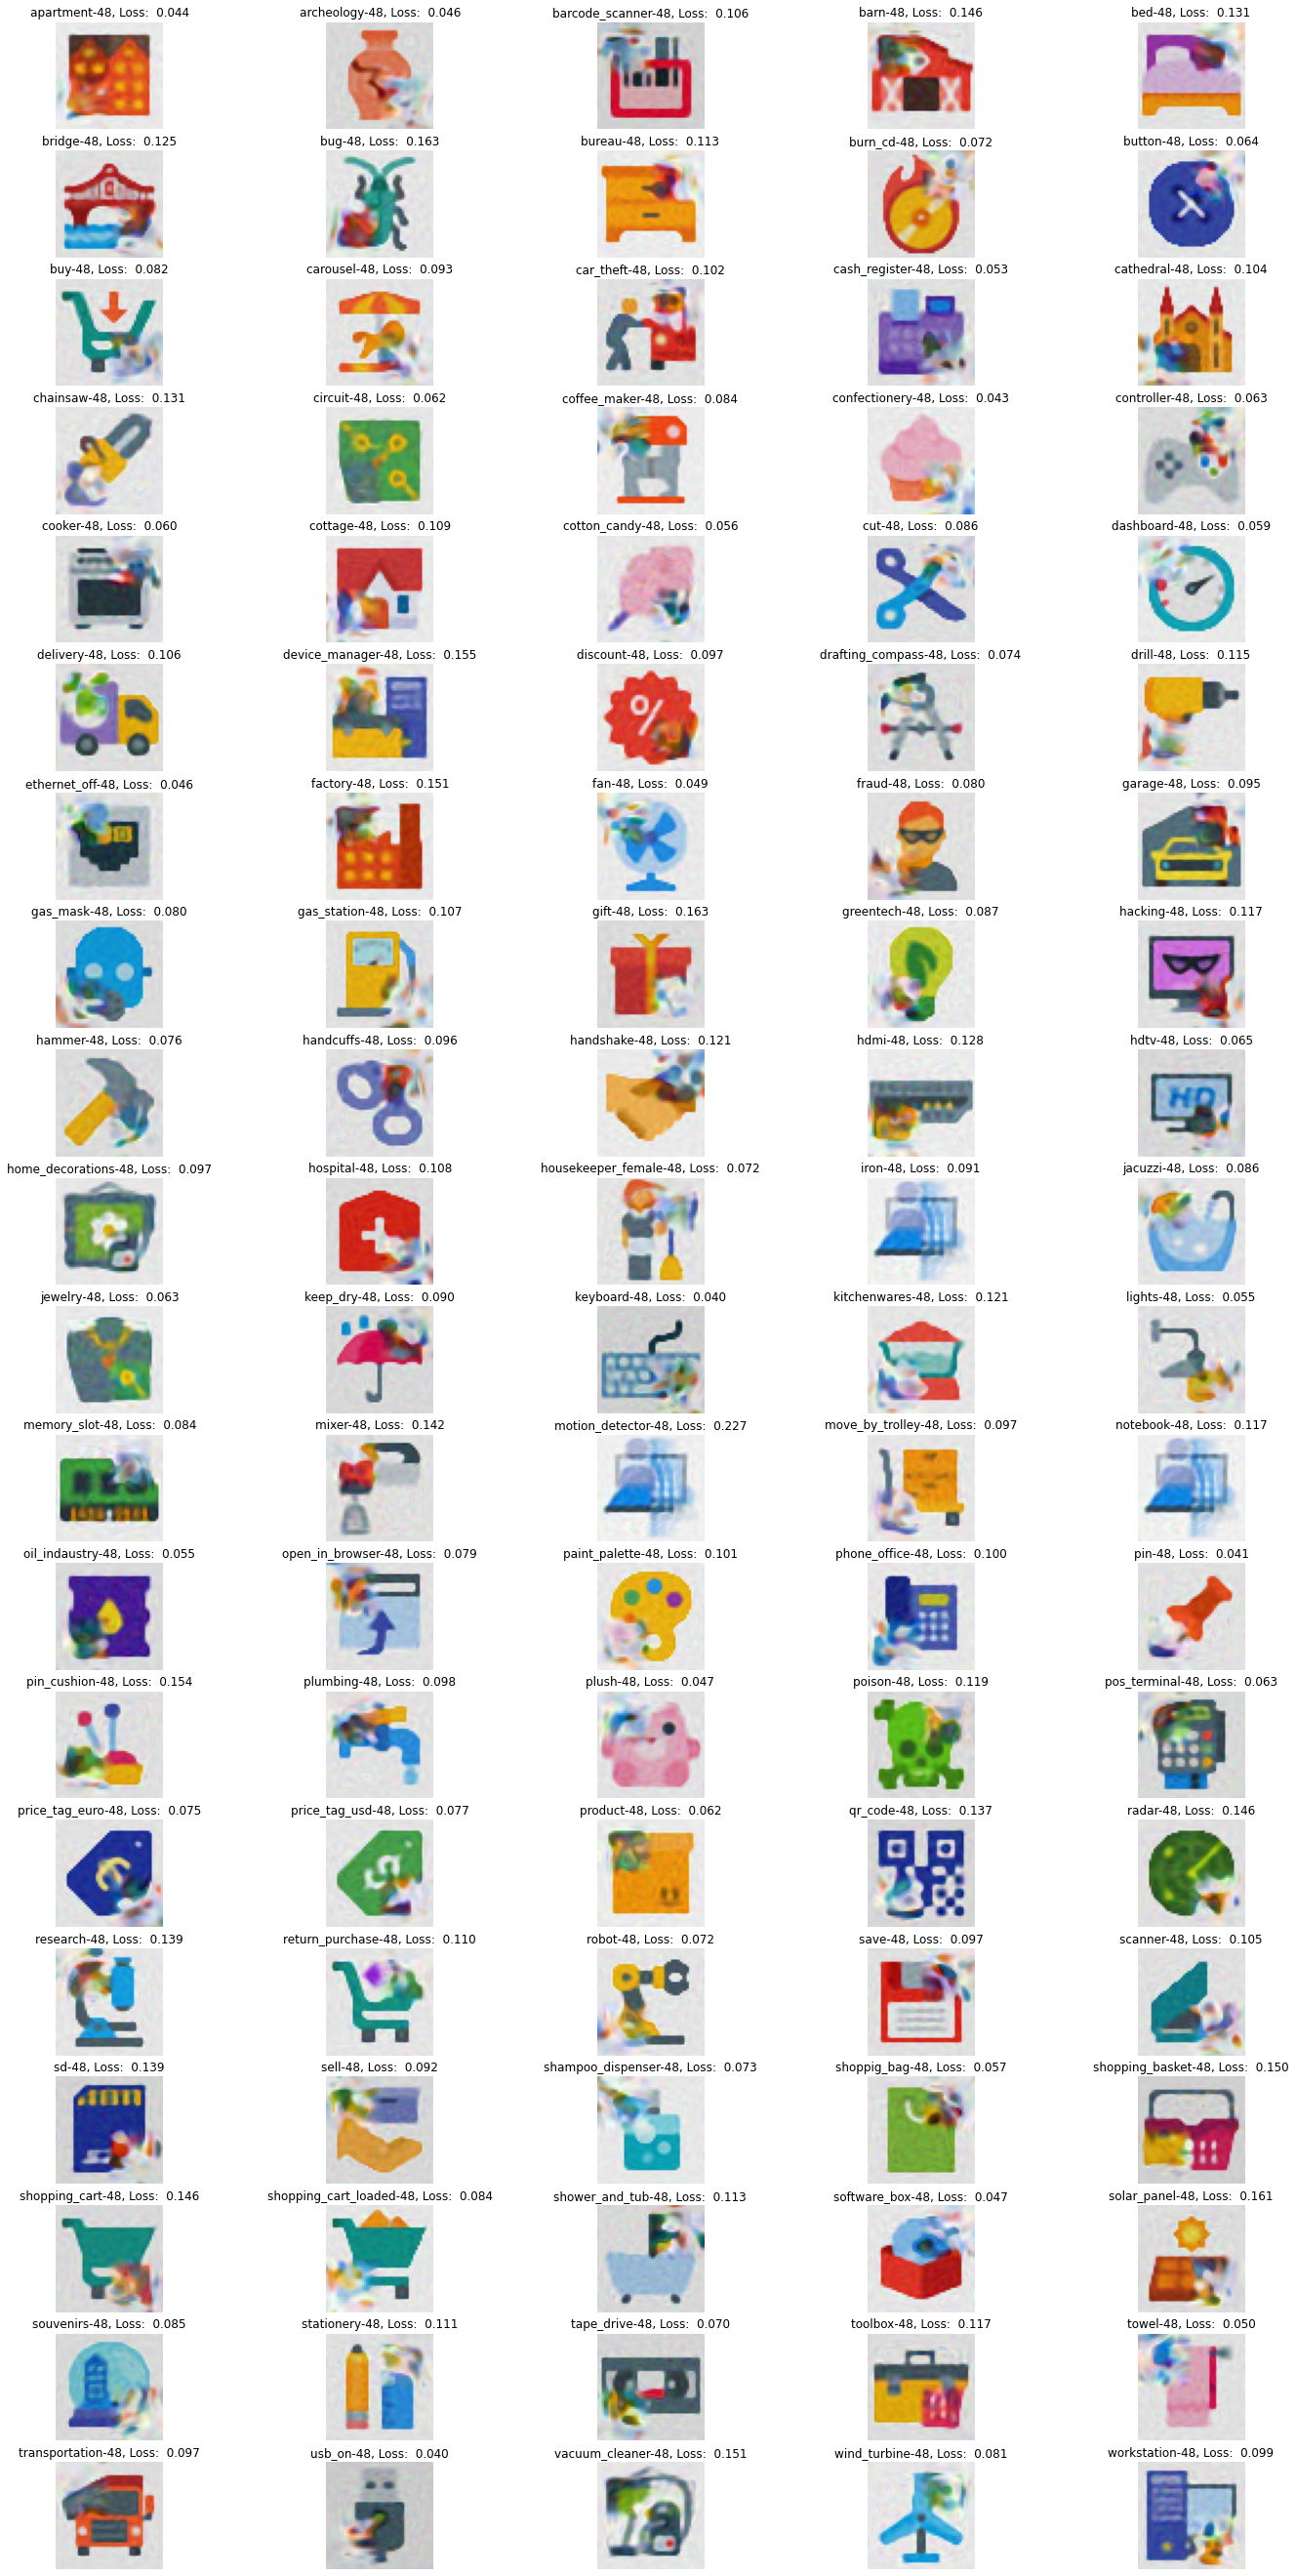

In [146]:
fig, axs = plt.subplots(20, 5, figsize=[24,48])
dataloader = DataLoader(val_ds, batch_size=1, pin_memory=True, num_workers=0)
plot_all_images(dataloader)

## Analysis

Results are somehow much worse than the version with the large embedding vector.  
Need to be further investigated...